# Part 5: Revisiting the rotor model (optional)

In this section we will extend and improve the rotor aerodynamics model, at this point likely the least accurate part of our multirotor model.
We will use the widely used blade element momentum theory (BEMT), in which we approximate the forces and moments as the integrals of contributions from 2D airfoil slices.
The new rotor aerodynamics model can be implemented in the same framework we have been using up to this point, enabling us to re-use all of our existing code and create highly configurable vehicle models.

A key step of the BEMT solver is the determination of an inflow parameter that is consistent with both the integrated 2D airfoil contributions and an overall momentum balance.
Typically this is accomplished with nested iterative solves, but we will see how the implicit function capabilities of Archimedes can make the implementation both simpler and more efficient.

## Blade element theory

So far we have been using the quadratic model

$$
\begin{align*}
\mathbf{F}_{H_j}^j &= -k_F \Omega_j^2 \hat{\mathbf{z}} \\
\mathbf{M}_{H_j}^j &= k_M \Omega_j^2 \hat{\mathbf{z}},
\end{align*}
$$

where $\hat{\mathbf{z}}$ is a unit vector along the hub-frame $z$-axis and $H_j$ is the hub reference frame for the $j$-th rotor.
The problem with this model is that it does not account for the actual airflow across the rotor in any way.
For instance, if the vehicle is moving forward, the rotor can experience a significantly increased airflow on the advancing side and reduced airflow on the retreating side, which can have a pronounced effect on the generated forces and moments.

The basic idea of blade element theory is to consider a thin "slice" of the blade with infinitesimal thickness $dr$ as a 2D airfoil and calculate its contribution to the net force and moment produced by the rotor.
To facilitate this, we must introduce two new reference frames related to the rotor hub frame $H$.
We will drop the subscript $j$ since we are focusing on a single rotor for now; the `MultiRotorVehicle` class will still take care of summing the contributions from each of the rotors.

The new first reference frame is the "wind frame" W, defined so that the $x-y$ plane is still coincident with the rotor plane, but the incoming airflow is in the $x-z$ plane.
Specifically, if we ignore any true "wind" and assume the ambient air is still in the inertial reference frame, then the relative motion of the air with respect to the hub frame is the negative of the body-frame velocity, rotated into the hub frame:

$$
\mathbf{w}_H = - ~^H\!\mathbf{C}^B \mathbf{v}_B.
$$

Then the incident wind angle with respect to the hub-frame $x$-axis is

$$
\psi_w = \tan^{-1}(w_H^y / w_H^x)
$$

and the (time-varying) rotation matrix from the hub frame to the wind frame $~^W\!\mathbf{C}^H$ is defined by a right-handed rotation of $\psi_w$ about the hub-frame $z$-axis:

$$
~^W\!\mathbf{C}^H =
\begin{bmatrix}
\cos \psi_w & \sin \psi_w & 0 \\
-\sin \psi_w & \cos \psi_w & 0 \\
0 & 0 & 1
\end{bmatrix}
$$

The final reference frame we will need is the "blade" frame.  If a single rotor blade is at azimuthal location $\psi$ (defined with respect to the negative wind-frame $x$-axis) and we consider a cross-sectional slice of the blade at radial location $r$, we can attach a reference frame $b$ at the point $(r, \psi)$, defined so that the $x$-axis is oriented opposite to the rotation of the blade and the $z$-axis is opposite to the wind-frame $z$-axis (i.e. up).
The new reference frames are illustrated in the following figure:


```{image} _static/frames2.png
:class: only-light
```

```{image} _static/frames2_dark.png
:class: only-dark
```
    

In summary, to consider a single rotor blade we have five reference frames to contend with:

1. The Newtonian or inertial frame $N$
2. The body-fixed frame $B$, offset and oriented with respect to $N$ according to the state variables $\mathbf{p}_N$ and $\mathbf{\Phi}$.
3. The rotor hub frame $H$, offset and canted with respect to $B$ by fixed geometric parameters
4. The wind frame $W$, defined by a time-varying rotation about the hub-frame $z$-axis by $\psi_w$
5. The blade frame $b$, defined relative to the wind frame according to the polar coordinates $(r, \psi)$.

With these frames defined, we can calculate infinitesimal contributions to lift, drag, and moment due to the 2D airfoil section at $(r, \psi)$ in the blade frame.
In general the dimensionless sectional aerodynamic coefficients $C_L$, $C_D$, and $C_M$ are taken to be functions of angle of attack $\alpha$, Reynolds number, and Mach number, although the dependence on Reynolds and Mach number is often treated with empirical corrections or neglected.
The aerodynamic coefficients can be looked up in tabulated experimental or CFD data, or approximated with an analytic form like thin airfoil theory.

The angle of attack is a function of both the fixed blade pitch $\theta_b$, which typically varies along the span of the blade and the "inflow angle" $\gamma$, corresponding to the "flight path angle" used in fixed-wing flight dynamics.
The inflow angle is the inclination with respect to the blade-frame $x$-axis of the blade-relative airflow $\mathbf{u}_b$, which is _not the same_ as the blade-frame wind vector $\mathbf{w}_b$.
If the instantaneous rotor angular velocity is $\Omega$, the blade-relative airflow is calculated as follows:

$$
\begin{align*}
u_b^x &= w_b^x \sin \psi - r \omega_b^z + \Omega r \\
u_b^z &= -w_b^z  + r \omega_b^y - \lambda \Omega R,
\end{align*}
$$

where $\mathbf{\omega}_b$ is the blade-frame angular velocity of the vehicle and $\lambda$ is a dimensionless "inflow ratio" that accounts for the induced vertical velocity required by conservation of momentum when the rotor is producing thrust.
Generally $\lambda$ will depend on the translational and angular velocity of the vehicle, the location $(r, \psi)$ of the blade element, and the instantaneous state of the wake if this is taken into account.
The determination of $\lambda$ is the most difficult aspect of blade element theory; we will return to this shortly.

Once the blade-relative airflow is computed, the inflow angle is given by

$$
\gamma = \tan^{-1} (-u_b^z/u_b^x)
$$

and the angle of attack is simply

$$
\alpha = \theta_b(r) - \gamma.
$$

This value is then used in conjunction with the local Reynolds and Mach numbers to determine the lift, drag, and moment coefficients $C_L$, $C_D$, and $C_M$.
The infinitesimal contributions to lift, drag, and moment from this 2D blade section with are

$$
\begin{align*}
dL &= \frac{1}{2} \rho c U_\infty^2 C_L ~ dr \\
dD &= \frac{1}{2} \rho c U_\infty^2 C_D ~ dr \\
dM &= \frac{1}{2} \rho c^2 U_\infty^2 C_M,
\end{align*}
$$

where $U_\infty^2 = ||\mathbf{u}_b||^2$ is the freestream velocity, $\rho$ is the air density, and $c$ is the local blade chord (which may also vary as a function of radial location $r$).

By definition, the drag is in the direction of the inflow $\mathbf{u}_b$ and the lift is perpendicular to it.
These must be rotated about the blade-frame $y$-axis by the inflow angle $\gamma$ to retrieve the infinitesimal blade-frame forces:

$$
d\mathbf{F}_b
=
\begin{bmatrix}
\cos \gamma & 0 & -\sin \gamma\\
0 & 1 & 0 \\
\sin \gamma & 0 & \cos \gamma
\end{bmatrix}
\begin{bmatrix}
dL \\ 0 \\ dD
\end{bmatrix}.
$$

Here the "blade frame" is no longer well-defined since we have removed the radial position, so this force should be taken as located at the blade root with orientation still consistent with the azimuthal coordinate $\psi$.
The net force and moment due to a rotor blade at azimuthal location $\psi$ can then be calculated by integrating over the blade span:

$$
\begin{align*}
\mathbf{F}_b(\psi) &= \int d\mathbf{F}_b \\
\mathbf{M}_b(\psi) &= \int \hat{\mathbf{y}} dM + \int r\hat{\mathbf{y}} \times d\mathbf{F}_b.
\end{align*}
$$

These forces can be rotated into consistent wind frame forces and moments $\mathbf{F}_W(\psi)$ and $\mathbf{M}_W(\psi)$ with the rotation matrix $~^W\!\mathbf{C}^b$, which is constant along the blade span.

Finally, since the rotors are typically spinning much faster than any relevant vehicle dynamics, it is common to average these forces over one rotation of the rotor blade, and scale the result by the number of rotor blades $N_b$:

$$
\begin{align*}
\overline{\mathbf{F}}_W(\psi) &= \frac{N_b}{2 \pi} \int_0^{2\pi} \mathbf{F}_W(\psi) ~ d \psi \\
\overline{\mathbf{M}}_W(\psi) &= \frac{N_b}{2 \pi} \int_0^{2\pi} \mathbf{M}_W(\psi) ~ d \psi.
\end{align*}
$$

If the rotor is spinning clockwise, then the same analysis applies but the sign is reversed on $\overline{F}_W^y$, $\overline{M}_W^x$, and $\overline{M}_W^z$.

Numerically, these integrals can be evaluated with Gaussian quadrature; the radial and azimuthal nodes are determined ahead of time and the infinitesimal forces can be evaluated at each $(r, \psi)$ node location, then summed with the quadrature weights to approximate the integral.

## Uniform inflow approximation: momentum theory

We now return to the final ingredient in the blade element theory: the inflow ratio $\lambda$.
While there are a number of models to choose from that treat the wake with varying degrees of fidelity, perhaps the simplest is momentum theory.
The basic premise of momentum theory is Newton's third law: every action has an equal and opposite reaction.
More precisely for present purposes, if the rotor is imparting thrust (a change in momentum over time) to the vehicle, the momentum of the surrounding air must also be increased by the same amount.

The basic approximation of momentum theory is that the inflow ratio $\lambda$ is constant across the rotor disk.
In the case of steady hover or forward flight a basic momentum balance calculation can be carried out (see for instance the reference text by Leishman) for any value of $\lambda$ to determine a corresponding thrust coefficient $C_T^\mathrm{mom}$.
Defining $\mu_x = w_W^x / \Omega R$ and $\mu_z = w_W^z / \Omega R$ as the relative velocities nondimensionalized by tip speed $\Omega R$, momentum balance predicts a thrust coefficient

$$
C_T^\mathrm{mom}(\lambda) = 2(\lambda - \mu_z) \sqrt{\mu_x^2 - \lambda^2}.
$$

On the other hand, for the same value of $\lambda$ the blade element method independently determines a value of the thrust coefficient by nondimensionalizing the predicted $z$-component of wind-frame force:

$$
\overline{F}_W^z(\lambda) = \rho A \left(\Omega R\right)^2 C_T^\mathrm{bem},
$$

where $A = \pi R^2$ is the rotor disk area.

If we require that $\lambda$ must have a value such that $C_T^\mathrm{mom}$ and $C_T^\mathrm{bem}$ are consistent for the instantaneous velocity (i.e. assuming the vehicle were to be in steady level flight at that velocity), this gives us two equations in two unknowns.  In other words, by requiring that $C_T^\mathrm{mom} = C_T^\mathrm{bem}$, we have a single equation that implicitly defines $\lambda$:

$$
2(\lambda - \mu_z) \sqrt{\mu_x^2 - \lambda^2} = \frac{\overline{F}_W^z(\lambda)}{\rho \pi \Omega^2 R^4}.
$$

Specifically, given the vehicle state $\mathbf{x}$ and the rotor velocity $\Omega$, we can define a "residual" function that should be zero when the value of $\lambda$ is consistent with both the blade element method and momentum balance:

$$
F(\lambda, \mathbf{x}, \Omega) = C_T^\mathrm{mom} - C_T^\mathrm{bem} = 0.
$$

This can be viewed as an implicit function $\lambda = f(\mathbf{x}, \Omega)$, where we cannot write a closed-form expression for $f$.
In principle, a single root solve using for instance the Newton-Raphson method could be used to find the zero of the function $F$ for given $\mathbf{x}$ and $\Omega$, thereby determining $\lambda$.
However, this would require being able to efficiently compute the Jacobians $\partial F/ \partial \lambda$, $\partial F / \partial \mathbf{x}$, and $\partial F / \partial \Omega$, which requires differentiating through both the momentum balance equation (which is straightforward) and the blade element thrust calculation (which is not).

As a result, in practice an appropriate value of $\lambda$ is typically determined with nested iterative solvers.
First, for a candidate value of the thrust coefficient $C_T^\mathrm{mom}$ and the current values of $\mu_x$ and $\mu_z$, the Newton-Raphson method is used to solve for the corresponding value $\lambda$ required by momentum balance.
This value of $\lambda$ is then used for the thrust calculation in the blade element method, which in general will result in a _different_ value of the thrust coefficient, i.e. $C_T^\mathrm{bem} \neq C_T^\mathrm{mom}$.
Some combination of the new and old values of the thrust coefficient are then used for the next iteration of the Newton-Raphson solver.

Archimedes can significantly simplify this process with its implicit function capabilities, which combine automatic differentiation with root solving to easily and efficiently solve this kind of equation.
If we have a function like $F(x, z) = 0$ which we want to use as an implicit function $x = f(z)$ without writing $f$, in Archimedes we can simply do the following:

```python
def F(x, z):
    # ... compute and return residual
    
f = arc.implicit(F)
x = f(z)  # Find x such that F(x, z) = 0
```

The `implicit` function creates and returns a new function with the first argument removed (in this case `x`).
Under the hood, this function calls a Newton solver and uses CasADi's powerful automatic differentiation capabilities to evaluate the required Jacobians.

For the induced inflow ratio calculation, the implementation will look something like the following, where `v_W` is the wind-frame vehicle translational velocity $\mathbf{v}_W$ and `w_W` is the wind-frame vehicle angular velocity $\mathbf{\omega}_W$:

```python
def CT_residual(lambda_, v_W, w_W, Omega):
    mu_x = -v_W[0] / (Omega * R)
    mu_z = -v_W[2] / (Omega * R)
    CT_mom = 2 * (lambda_ - mu_z) * np.sqrt(mu_x ** 2 + lambda_ ** 2)
    CT_bem = calc_thrust(v_W, w_W, Omega, lambda_)
    return CT_mom - CT_bem

inflow_ratio = arc.implicit(CT_residual)
lambda_ = inflow_ratio(v_W, w_W, Omega)
```

This value of $\lambda$ is then used for the full blade-element calculation; the combination of this uniform inflow based on momentum balance with the blade-element method is called blade element momentum theory (BEMT).
If used with proper airfoil data it can be a fairly accurate approximation for steady flight, although the assumptions required by the momentum theory become fairly limiting for more aggressive maneuvers.

## Implementation

The blade element model fits neatly into the class structure we've already defined above, as a new implementation of the `RotorModel` interface.
We just need to implement the `wind_frame_loads` method, which computes the wind-frame loads $\mathbf{F}_W$ and $\mathbf{M}_W$ given the wind-frame vehicle translational and angular velocities $\mathbf{v}_W$ and $\mathbf{\omega}_W$, rotor speed $\Omega$, and the `RotorGeometry` struct.
The actual implementation of this class is relatively involved, though it closely follows the preceding math; see the source code in `multirotor.py` for details.
Although the `BladeElementModel` implements the BEMT method described above, it is also written to be extensible for variable inflow ratio models or "dynamic inflow" models that have auxiliary state variables.

One new addition to the classes in our framework is an `AirfoilModel` used to compute the aerodynamic coefficients $C_L$, $C_D$, $C_M$ for a 2D "blade element" as a function of angle of attack, Reynolds number, and freestream Mach number:

```python
class AirfoilModel(metaclass=abc.ABCMeta):
    """Model for aerodynamics of a 2D subsonic airfoil section."""

    compressibility_model: str = None

    @abc.abstractmethod
    def __call__(self, alpha, Re, M_inf):
        """Returns lift, drag, and moment coefficients for the given angle of attack
        
        Args:
            alpha: angle of attack [rad]
            Re: Reynolds number
            M_inf: freestream Mach number
        
        Returns:
            Cl: lift coefficient
            Cd: drag coefficient
            Cm: quarter-chord moment coefficient
        """
```

As with gravity, vehicle drag, and the rotor aerodynamics, creating a well-defined interface allows us to create very different models that are compatible with the rest of the framework.
For instance, the tutorial module `multirotor.py` contains a simple `ThinAirfoil` class that will compute coefficients consistent with ideal-fluid aerodynamics solutions for thin airfoils with small angle of attack.
It also implements a `TabulatedAirfoil` class which uses lookup tables to estimate the aerodynamic coefficients based on experimental or CFD data.
As a more computationally intensive example, a vortex panel code similar to XFOIL could also be implemented in the same interface and used in conjunction with automatic differentiation for design optimization.

```{image} _static/class_hierarchy2.png
:class: only-light
```

```{image} _static/class_hierarchy2_dark.png
:class: only-dark
```

## Running the blade element model

Because the BEMT rotor model simply extends the existing framework, we can create the model just as we did with the quadratic rotor model except with the additional initialization required for the BEMT model.

This example uses the `TabulatedAirfoil` model with lookup tables derived from the open-source CFD code [SU2](https://su2code.github.io/) using the NACA 0012 profile.
As a word of caution, typical rotor blades have significant camber, so this data is likely not representative of any particular rotor blade aerodynamics.
It should be used for illustrative purposes only.

Using the NACA 0012 data, we will initialize the blade element model using a linearly twisted blade from $20^\circ$ at the root to $10^\circ$ at the tip.  The chord length also varies linearly from 30 mm at the root to 10 mm at the tip.

In [ ]:
# ruff: noqa: N802, N803, N806, N815, N816
import os

import control
import matplotlib.pyplot as plt
import multirotor
import numpy as np

import archimedes as arc

THEME = os.environ.get("ARCHIMEDES_THEME", "dark")
arc.theme.set_theme(THEME)

np.set_printoptions(precision=3, suppress=True)

In [ ]:
# Inertia matrix of a cylinder with mass m, radius r, and height h
m = 2.0
g0 = 9.81
R = 0.15  # Rotor radius (also boom length)
H = 0.15  # Body height
J_B = np.array(
    [
        [m / 12 * (3 * R**2 + H**2), 0, 0],
        [0, m / 12 * (3 * R**2 + H**2), 0],
        [0, 0, m / 2 * R**2],
    ]
)
L = 0.30  # Rotor arm length

# Four rotors mounted at 45, 135, 225, and 315 degrees
# No canting and alternating spin directions
rotors = []
theta = np.pi / 4
ccw = True
for i in range(4):
    rotors.append(
        multirotor.RotorGeometry(
            offset=np.array([L * np.cos(theta), L * np.sin(theta), 0]),
            ccw=ccw,
        )
    )
    theta += np.pi / 2
    ccw = not ccw

drag_model = multirotor.QuadraticDragModel(
    rho=1.225,
    Cd=1.6,
    A=R * H,
)

gravity_model = multirotor.ConstantGravity(g0=g0)

c0 = 0.03  # Root chord
th0 = np.deg2rad(20.0)  # Root pitch
ct = 0.01  # Tip chord
tht = np.deg2rad(-10.0)  # Twist per unit length
e = 0.1  # Root cut-out ratio


def chord(r_):
    r_bar = r_ / R
    return (c0 * (1 - r_bar) + ct * (r_bar - e)) / (1 - e)


def pitch(r_):
    r_bar = r_ / R
    return th0 + tht * (r_bar - e) / (1 - e)


airfoil_model = multirotor.TabulatedAirfoil(
    airfoil_data=[multirotor.NACA_0012, multirotor.NACA_0012],
    rad_loc=[e * R, R],
)

T0 = m * g0 / len(rotors)  # Initial guess for trim thrust
rotor_model = multirotor.BladeElementModel(
    R=R,
    e=e,
    T0=T0,
    airfoil_model=airfoil_model,
    chord=chord,
    blade_pitch=pitch,
)

vehicle = multirotor.MultiRotorVehicle(
    m=m,
    J_B=J_B,
    rotors=rotors,
    drag_model=drag_model,
    rotor_model=rotor_model,
    gravity_model=gravity_model,
    attitude="euler",
)

As before, we will use a constant angular velocity close to hover.
The only difference now has to do with the use of the lookup tables.
The symbolic interpolant used behind the scenes by CasADi is not compatible with the default scalar ("SX") symbolic type and requires the matrix ("MX") symbolic type.
Hence, we have to explicitly create an "MX" symbolic function before calling the `odeint` function:

Text(0.5, 0, 'Time [s]')

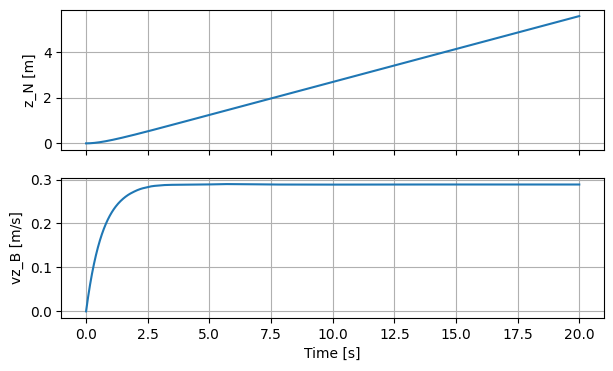

In [10]:
u0 = 500.0 * np.ones(4)  # Rotor angular velocity (rad/s)

t0 = 0.0
t1 = 20.0


# Initial state for simulation
x0 = vehicle.State(
    p_N=np.zeros(3),  # Initial position [m]
    att=np.zeros(3),  # Initial roll-pitch-yaw [rad]
    v_B=np.zeros(3),  # Initial velocity [m/s]
    w_B=np.zeros(3),  # Initial angular velocity [rad/s]
)
x0_flat, unravel = arc.tree.ravel(x0)

# vmap_unravel will convert a flat solution (x, t) to a vehicle.State
vmap_unravel = arc.vmap(unravel, in_axes=1, out_axes=1)


# Wrap the vehicle dynamics model in a function with
# the signature `xdot = f(t, x)`
@arc.compile
def f(t, x_flat):
    x = unravel(x_flat)
    x_t = vehicle.dynamics(t, x, u0)
    return arc.tree.ravel(x_t)[0]  # Return only the flattened state


t_span = (t0, t1)
t_eval = np.linspace(*t_span, 1000)
xs_flat = arc.odeint(f, t_span, x0_flat, t_eval=t_eval)
xs = vmap_unravel(xs_flat)  # Return to vehicle.State format

fig, ax = plt.subplots(2, 1, figsize=(7, 4), sharex=True)
ax[0].plot(t_eval, xs.p_N[2])
ax[0].grid()
ax[0].set_ylabel("z_N [m]")
ax[1].plot(t_eval, xs.v_B[2])
ax[1].grid()
ax[1].set_ylabel("vz_B [m/s]")
plt.xlabel("Time [s]")

The same idea about "MX" symbolics apply to identifying a trim point and performing linear stability analysis.
As a general rule, it's safe to use the default "MX" symbolics - if you want to try improving performance you can experiment with creating "SX" functions, provided they don't contain unsupported operations like root-finding or interpolation.

In [ ]:
# Trim point identification

v_N = np.array([10.0, 0.0, 0.0])  # Target forward velocity in the inertial frame
p_N = np.zeros(3)  # Arbitrary position
w_B = np.zeros(3)  # Target angular velocity in the body frame


@arc.compile
def residual(p):
    phi, theta = p[:2]  # (pitch, roll) angles
    u = p[2:]  # Rotor angular velocities
    rpy = np.array([phi, theta, 0.0], like=p)
    C_BN = multirotor.dcm(rpy)
    v_B = C_BN @ v_N
    x = vehicle.State(p_N, rpy, v_B, w_B)
    x_t = vehicle.dynamics(0.0, x, u)
    return np.hstack([x_t.v_B, x_t.w_B])  # Residuals of dynamics equations only


u0 = 500.0
p0 = np.array([0.0, 0.0, u0, u0, u0, u0])

p_trim = arc.root(residual, p0)

phi_trim = p_trim[0]
theta_trim = p_trim[1]
u_trim = p_trim[2:]

rpy_trim = np.array([phi_trim, theta_trim, 0.0])
C_BN = multirotor.dcm(rpy_trim)
v_B_trim = C_BN @ v_N

x_trim = vehicle.State(p_N, rpy_trim, v_B_trim, w_B)

print(f"roll: {np.rad2deg(phi_trim):.2f} deg")
print(f"pitch: {np.rad2deg(theta_trim):.2f} deg")
print(f"v_B: {v_B_trim}")
print(f"u: {u_trim}")

roll: -0.00 deg
pitch: -8.83 deg
v_B: [ 9.881  0.    -1.535]
u: [512.53  512.517 512.517 512.53 ]


In [ ]:
# Longitudinal dynamics include surge (vx), heave (vz), pitch (theta),
# and pitch rate (q). The other states are assumed to be in trim
def longitudinal_dofs(x):
    return np.hstack(
        [
            x.att[1],  # theta
            x.v_B[0],  # vx
            x.v_B[2],  # vz
            x.w_B[1],  # q
        ]
    )


# Right-hand side function for the longitudinal dynamics
def f_lon(x_lon, u):
    theta, vx, vz, q = x_lon  # Longitudinal degrees of freedom
    x = vehicle.State(
        np.zeros(3),
        np.hstack([phi_trim, theta, 0.0]),
        np.hstack([vx, v_B_trim[1], vz]),
        np.hstack([0.0, q, 0.0]),
    )
    x_t = vehicle.dynamics(0.0, x, u)
    return longitudinal_dofs(x_t)


x_lon_trim = longitudinal_dofs(x_trim)

# Linearized state-space matrices
A_lon = arc.jac(f_lon, 0)(x_lon_trim, u_trim)
B_lon = arc.jac(f_lon, 1)(x_lon_trim, u_trim)

print(f"A_lon:\n{A_lon}")
print(f"\nB_lon:\n{B_lon}")

A_lon:
[[ 0.     0.     0.     1.   ]
 [-9.694 -0.259  0.03   1.535]
 [ 1.506 -0.288 -2.135  9.882]
 [ 0.    -0.004  0.011 -0.958]]

B_lon:
[[ 0.     0.     0.     0.   ]
 [-0.    -0.    -0.    -0.   ]
 [-0.01  -0.01  -0.01  -0.01 ]
 [ 0.274 -0.273 -0.273  0.274]]


As a result of the much richer aerodynamics model, the longitudinal dynamics are more strongly coupled, as seen in the more interesting behavior of the transfer functions between a uniform input to all four rotors and the longitudinal state variables:

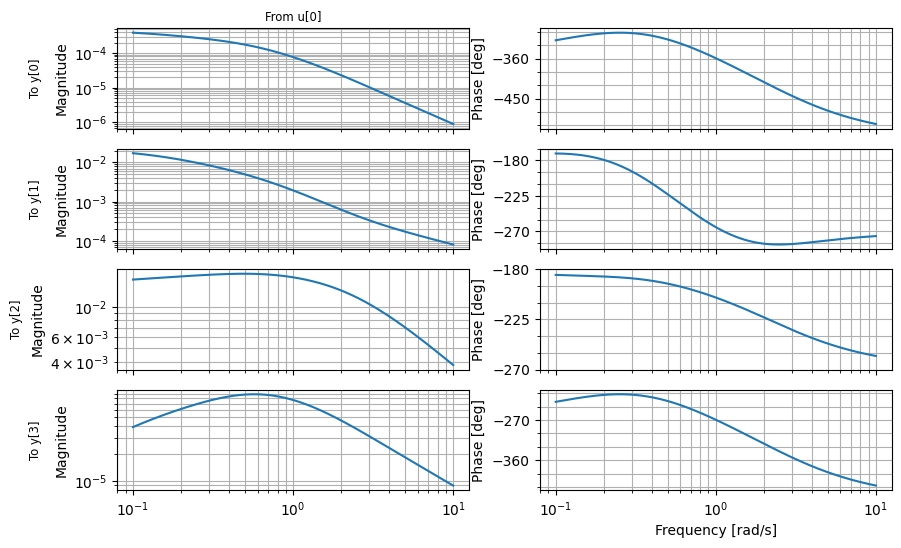

In [13]:
C_hat = np.eye(4)
B_hat = B_lon @ np.ones((4, 1))
D_lon = np.zeros((C_hat.shape[0], 1))

lti_sys = control.StateSpace(A_lon, B_hat, C_hat, D_lon)
fig, ax = plt.subplots(4, 2, figsize=(10, 6), sharex=True)
control.bode_plot(lti_sys, ax=ax)
plt.show()